In [19]:
import kagglehub
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from scipy.stats import chi2
import os

pd.options.display.float_format = '{:.2f}'.format

In [20]:
path = kagglehub.dataset_download("fronkongames/steam-games-dataset")

print("Path:", path)

csv_path = os.path.join(path, "games.csv")

df = pd.read_csv(csv_path, index_col=False, quotechar='"')

pd.set_option('display.max_columns', None)
df.head()

Path: /Users/kavuk/.cache/kagglehub/datasets/fronkongames/steam-games-dataset/versions/31


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,Full audio languages,Reviews,Header image,Website,Support url,Support email,Windows,Mac,Linux,Metacritic score,Metacritic url,User score,Positive,Negative,Score rank,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,2539430,Black Dragon Mage Playtest,"Aug 1, 2023",0 - 0,0,0,0.00,0,0,NaN,[],[],NaN,https://shared.akamai.steamstatic.com/store_it...,NaN,NaN,NaN,True,False,False,0,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,NaN,NaN,NaN,NaN,NaN,https://shared.akamai.steamstatic.com/store_it...
1,496350,Supipara - Chapter 1 Spring Has Come!,"Jul 29, 2016",0 - 20000,0,0,5.24,65,0,"Springtime, April: when the cherry trees come ...",['English'],[],NaN,https://shared.akamai.steamstatic.com/store_it...,http://mangagamer.org/supipara,http://mangagamer.com,support@mangagamer.com,True,False,False,0,NaN,0,252,3,NaN,0,231,NaN,8,0,8,0,minori,MangaGamer,"Single-player,Steam Trading Cards,Steam Cloud,...",Adventure,"Adventure,Visual Novel,Anime,Cute",https://shared.akamai.steamstatic.com/store_it...
2,1034400,Mystery Solitaire The Black Raven,"May 6, 2019",0 - 20000,0,0,4.99,0,0,"Immerse yourself in the most beloved, mystical...","['English', 'French', 'German', 'Russian']",[],NaN,https://shared.akamai.steamstatic.com/store_it...,https://www.facebook.com/8FloorGames/,https://www.facebook.com/8FloorGames,support@8floor.net,True,True,False,0,NaN,0,21,3,NaN,0,0,NaN,0,0,0,0,Somer Games,8floor,"Single-player,Family Sharing",Casual,"Casual,Card Game,Solitaire,Puzzle,Hidden Objec...",https://shared.akamai.steamstatic.com/store_it...
3,3292190,버튜버 파라노이아 - Vtuber Paranoia,"Oct 31, 2024",0 - 20000,1,0,8.99,0,1,"synopsis 'Hello, I'm Hiyoro, a new YouTuber!' ...",['Korean'],['Korean'],NaN,https://shared.akamai.steamstatic.com/store_it...,NaN,NaN,yujingamesc@gmail.com,True,False,False,0,NaN,0,0,0,NaN,19,0,The game includes the following elements. 1. G...,0,0,0,0,유진게임즈,유진게임즈,"Single-player,Steam Achievements,Family Sharing","Casual,Indie,Simulation",NaN,https://shared.akamai.steamstatic.com/store_it...
4,3631080,Maze Quest VR,"Apr 24, 2025",0 - 20000,0,0,4.99,0,0,Its not just a Maze; its a Quest! Enter the ca...,['English'],['English'],NaN,https://shared.akamai.steamstatic.com/store_it...,https://www.realityexpanded.com/books-games,https://www.realityexpanded.com,support@realityexpanded.com,True,False,False,0,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,Reality Expanded LLC,Reality Expanded LLC,"Single-player,VR Only,Steam Leaderboards,Famil...","Action,Early Access",NaN,https://shared.akamai.steamstatic.com/store_it...


In [21]:
df.columns = [c.replace(' ', '_').lower() for c in df.columns]

drop_cols = ['header_image', 'website', 'support_url', 'support_email', 'metacritic_url']
df = df.drop(columns=drop_cols)

df = df.dropna(subset=['price', 'peak_ccu'])

print(df.columns)

Index(['appid', 'name', 'release_date', 'estimated_owners', 'peak_ccu',
       'required_age', 'price', 'discountdlc_count', 'about_the_game',
       'supported_languages', 'full_audio_languages', 'reviews', 'windows',
       'mac', 'linux', 'metacritic_score', 'user_score', 'positive',
       'negative', 'score_rank', 'achievements', 'recommendations', 'notes',
       'average_playtime_forever', 'average_playtime_two_weeks',
       'median_playtime_forever', 'median_playtime_two_weeks', 'developers',
       'publishers', 'categories', 'genres', 'tags', 'screenshots', 'movies'],
      dtype='object')


In [22]:
df['nega_notes_ratio'] = df['negative'] / (df['notes'] + 1)
df['log_ccu'] = np.log(df['peak_ccu'] + 1)
df['log_negative'] = np.log(df['negative'] + 1)
df['log_notes'] = np.log(df['notes'] + 1)
df['log_median_playtime'] = np.log1p(df['median_playtime_forever'])

In [23]:
df.sample(n=10)

,appid,name,release_date,estimated_owners,peak_ccu,required_age,price,discountdlc_count,about_the_game,supported_languages,full_audio_languages,reviews,windows,mac,linux,metacritic_score,user_score,positive,negative,score_rank,achievements,recommendations,notes,average_playtime_forever,average_playtime_two_weeks,median_playtime_forever,median_playtime_two_weeks,developers,publishers,categories,genres,tags,screenshots,movies,nega_notes_ratio,log_ccu,log_negative,log_notes,log_median_playtime
65222,1623660,MIR4,"Aug 25, 2021",0 - 0,0,0,0.00,0,0,Venture into the open world of MIR and start y...,"['English', 'Traditional Chinese', 'Japanese',...",['Korean'],support@wemade.com,True,False,False,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,Wemade Next,Wemade,"Multi-player,MMO,PvP,Online PvP,Co-op,Online C...","Action,Adventure,Massively Multiplayer,RPG,Fre...",NaN,https://shared.akamai.steamstatic.com/store_it...,0.00,0.00,0.00,0.00,0.00
120744,1105730,HANGMAN,"Jul 24, 2019",50000 - 100000,0,0,0.72,0,0,The purpose of the puzzle is to guess the unkn...,"['English', 'French', 'Italian', 'German', 'Sp...",[],andreydubrovskynsk@gmail.com,True,False,False,NaN,0,28,11,NaN,33,0,NaN,0,0,0,0,Gamesforfarm,Gamesforfarm,"Single-player,Steam Achievements,Family Sharing","Casual,Indie","Horror,Casual,Indie,Dark,Word Game,Singleplaye...",https://shared.akamai.steamstatic.com/store_it...,28.00,0.00,3.37,0.00,0.00
34979,3196110,Randall the Grape Jelly Cube goes to Soda Vall...,"Dec 24, 2024",0 - 20000,0,0,1.99,0,0,Randall the Grape Jelly Cube looking thing is ...,['English'],[],ethan.w.smith@icloud.com,True,False,False,NaN,0,17,0,NaN,0,0,NaN,0,0,0,0,Ethan Smith,Ethan Smith,"Single-player,Partial Controller Support,Famil...",Adventure,"Adventure,Platformer,3D Platformer,Collectatho...",https://shared.akamai.steamstatic.com/store_it...,17.00,0.00,2.89,0.00,0.00
8411,346940,Shadowrun: Hong Kong - Extended Edition,"Aug 20, 2015",500000 - 1000000,25,0,4.99,0,1,Shadowrun: Hong Kong - Extended Edition is the...,['English'],[],NaN,True,True,True,https://www.metacritic.com/game/pc/shadowrun-h...,0,4030,614,NaN,60,3488,In this game there are textual references to v...,1031,0,629,0,Harebrained Schemes,Paradox Interactive,"Single-player,Steam Achievements,Steam Worksho...","Adventure,Indie,RPG,Strategy","RPG,Cyberpunk,Turn-Based,Isometric,Story Rich,...",https://shared.akamai.steamstatic.com/store_it...,1.16,3.26,8.30,8.16,0.00
76605,3108580,Grand Piano Simulator,"Aug 6, 2024",0 - 20000,1,0,9.09,30,0,"Welcome to Grand Piano Simulator, the most rea...","['English', 'French', 'German', 'Spanish - Spa...",[],NaN,True,False,False,NaN,0,8,0,NaN,16,0,NaN,0,0,0,0,kroland,kroland,"Single-player,Steam Achievements,Family Sharing","Indie,Simulation,Early Access","Simulation,Animation & Modeling,Rhythm,3D Plat...",https://shared.akamai.steamstatic.com/store_it...,8.00,0.69,2.20,0.00,0.00
117858,3674890,Phobies Playtest,"May 13, 2025",0 - 20000,0,0,0.00,0,0,Phobies Playtest Welcome a special Playtest ve...,"['English', 'French', 'Italian', 'German', 'Sp...","['English', 'Traditional Chinese']",support@phobiesholdingsinc.com,True,False,False,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,Smoking Gun Interactive Inc.,Phobies Holdings Inc.,"Multi-player,PvP,Online PvP,Cross-Platform Mul...","Indie,Strategy",NaN,https://shared.akamai.steamstatic.com/store_it...,0.00,0.00,0.00,0.00,0.00
46328,2166780,Galaxy Bricks,"Nov 23, 2023",0 - 20000,0,0,2.49,50,0,About Galaxy Bricks Galaxy Bricks is a mashup ...,['English'],[],Contact@emeraldknightinteractive.com,True,False,False,NaN,0,18,1,NaN,21,0,NaN,0,0,0,0,Emerald Knight Interactive LLC,Emerald Knight Interactive LLC,"Single-player,Steam Achievements,Steam Leaderb...","Action,Casual,Indie","Casual,Action,Indie,Shoot 'Em Up,Arcade,Retro,...",https://shared.akamai.steamstatic.com/store_it...,18.00,0.00,2.94,0.00,0.00
11708,2319300,Spiritoké,"Jul 10, 2024",0 - 20000,0,0,4.99,0,0,"The Spirit Compass has been shattered, taintin...",['English'],[],spiritokeofficial@gmail.

In [24]:
df.describe()

,appid,peak_ccu,required_age,price,discountdlc_count,about_the_game,positive,negative,score_rank,achievements,recommendations,notes,average_playtime_two_weeks,median_playtime_forever,median_playtime_two_weeks,developers,nega_notes_ratio,log_ccu,log_negative,log_notes,log_median_playtime
count,122611.00,122611.00,122611.00,122611.00,122611.00,122611.00,122611.00,122611.00,122611.00,40.00,122611.00,122611.00,122611.00,122611.00,122611.00,122611.00,122611.00,122611.00,122611.00,122611.00,122611.00
mean,1985385.74,54.59,0.17,4.77,18.35,0.55,0.02,1044.99,169.20,99.17,18.09,961.82,208.02,13.79,173.57,14.72,40.76,0.33,2.27,1.10,0.15
std,1087595.34,3729.45,1.65,12.53,28.86,14.52,1.39,28091.73,5374.64,0.68,141.49,21878.80,11217.68,270.38,11202.54,294.51,1151.13,1.04,2.40,2.51,0.88
min,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,98.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1063175.00,0.00,0.00,0.55,0.00,0.00,0.00,0.00,0.00,99.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1907380.00,0.00,0.00,2.24,0.00,0.00,0.00,5.00,1.00,99.00,2.00,0.00,0.00,0.00,0.00,0.00,1.02,0.00,1.79,0.00,0.00
75%,2869560.00,0.00,0.00,5.24,40.00,0.00,0.00,37.00,10.00,100.00,19.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,3.64,0.00,0.00
max,4264350.00,1013936.00,21.00,999.98,100.00,3703.00,100.00,7642084.00,1173003.00,100.00,9821.00,4830455.00,3429544.00,20088.00,3429544.00,20088.00,228817.00,13.83,15.85,15.39,9.91


In [25]:
print(df.isnull().sum())

appid                              0
name                               1
release_date                       0
estimated_owners                   0
peak_ccu                           0
required_age                       0
price                              0
discountdlc_count                  0
about_the_game                     0
supported_languages             8449
full_audio_languages               0
reviews                            0
windows                        22263
mac                                0
linux                              0
metacritic_score                   0
user_score                    118355
positive                           0
negative                           0
score_rank                         0
achievements                  122571
recommendations                    0
notes                              0
average_playtime_forever      100153
average_playtime_two_weeks         0
median_playtime_forever            0
median_playtime_two_weeks          0
d

In [26]:
df_active = df[df['peak_ccu'] > 0].copy()

df_100 = df[df['peak_ccu'] >= 100].copy()

df_1000 = df[df['peak_ccu'] >= 1000].copy()

comparison = pd.concat([
    df_100.describe(),
    df_1000.describe()
], axis = 1, keys = ['CCU >= 100', 'CCU >= 1000'])

display(comparison)

CCU >= 100                                                    \
           appid   peak_ccu required_age   price discountdlc_count   
count    1960.00    1960.00      1960.00 1960.00           1960.00   
mean  1191148.26    3330.29         2.51   10.34             39.42   
std    894178.65   29319.14         5.97   10.87             31.90   
min        10.00     100.00         0.00    0.00              0.00   
25%    413417.50     169.00         0.00    2.99              0.00   
50%   1042135.00     329.00         0.00    7.49             40.00   
75%   1767002.50    1002.00         0.00   14.99             70.00   
max   3697240.00 1013936.00        18.00   69.99            100.00   

                                                                  \
      about_the_game positive   negative score_rank achievements   
count        1960.00  1960.00    1960.00    1960.00         0.00   
mean           10.05     0.00   51290.77    7671.06          NaN   
std            96.00     0.00  215560.40   41617.15          NaN   
min             0.00     0.00       0.00       0.00          NaN   
25%             0.00     0.00    3597.50     492.00          NaN   
50%             1.00     0.00   12494.50    1704.00          NaN   
75%             5.00     0.00   36772.25    4726.50          NaN   
max          3703.00     0.00 7642084.00 1173003.00          NaN   

                                                             \
      recommendations      notes average_playtime_two_weeks   
count         1960.00    1960.00                    1960.00   
mean            56.98   42828.02                    3070.86   
std            103.08  156946.49                    7541.46   
min              0.00       0.00                       0.00   
25%             15.00    2527.25                     760.00   
50%             42.00   10757.50                    1365.00   
75%             66.25   31884.75                    2652.50   
max           2219.00 4830455.00                  170750.00   

                                                                    \
      median_playtime_forever median_playtime_two_weeks developers   
count                 1960.00                   1960.00    1960.00   
mean                   412.60                   1252.37     447.52   
std                   1013.10                   5206.33    1271.55   
min                      0.00                      0.00       0.00   
25%                     12.00                    267.75      13.00   
50%                    143.50                    501.00     134.50   
75%                    408.00                    933.00     390.75   
max                  13370.00                 140950.00   20014.00   

                                                                           \
      nega_notes_ratio log_ccu log_negative log_notes log_median_playtime   
count          1960.00 1960.00      1960.00   1960.00             1960.00   
mean           1073.27    6.22         9.19      8.50                4.19   
std            8836.07    1.42         2.24      3.19                2.51   
min               0.00    4.62         0.00      0.00                0.00   
25%               0.83    5.14         8.19      7.84                2.56   
50%               0.98    5.80         9.43      9.28                4.97   
75%               1.17    6.91        10.51     10.37                6.01   
max          228817.00   13.83        15.85     15.39                9.50   

      CCU >= 1000                                                   \
            appid   peak_ccu required_age  price discountdlc_count   
count      491.00     491.00       491.00 491.00            491.00   
mean   1198654.93   12355.57         3.40  12.36             38.06   
std     886939.88   57685.74         6.74  13.61             32.62   
min         10.00    1001.00         0.00   0.00              0.00   
25%     427465.00    1549.00         0.00   2.49              0.00   
50%    1086940.00    2777.00   

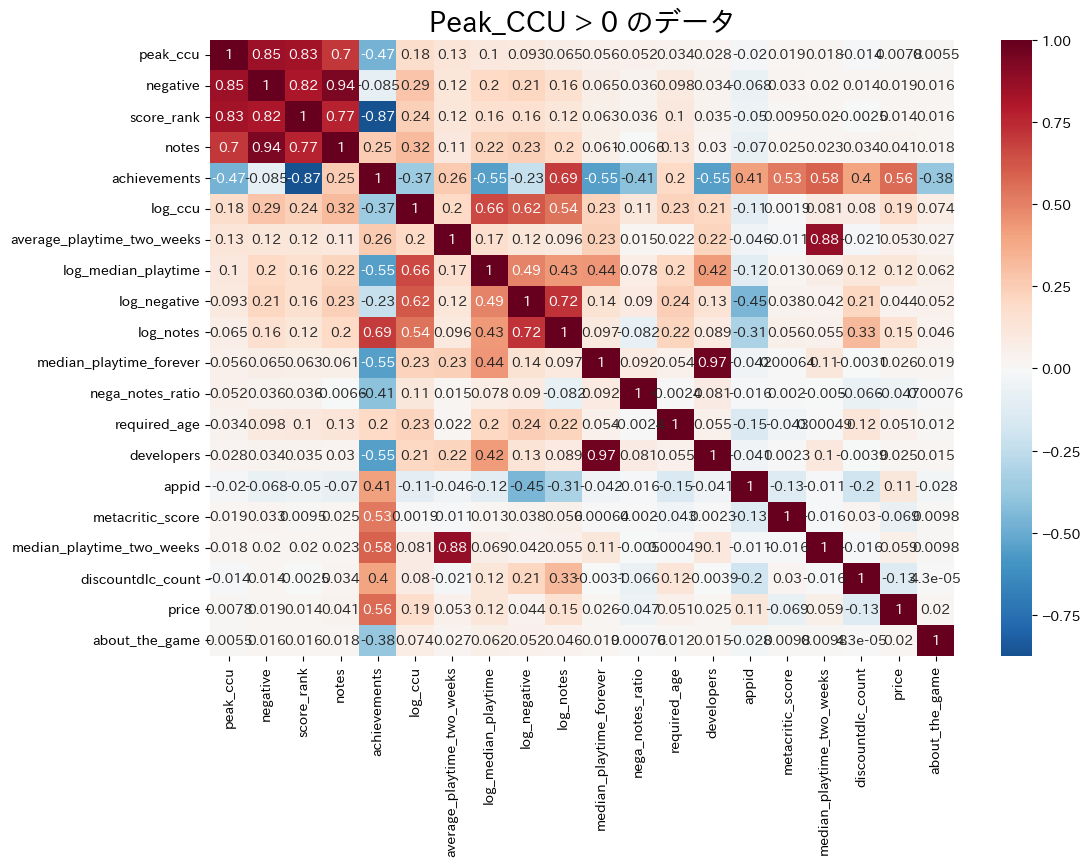

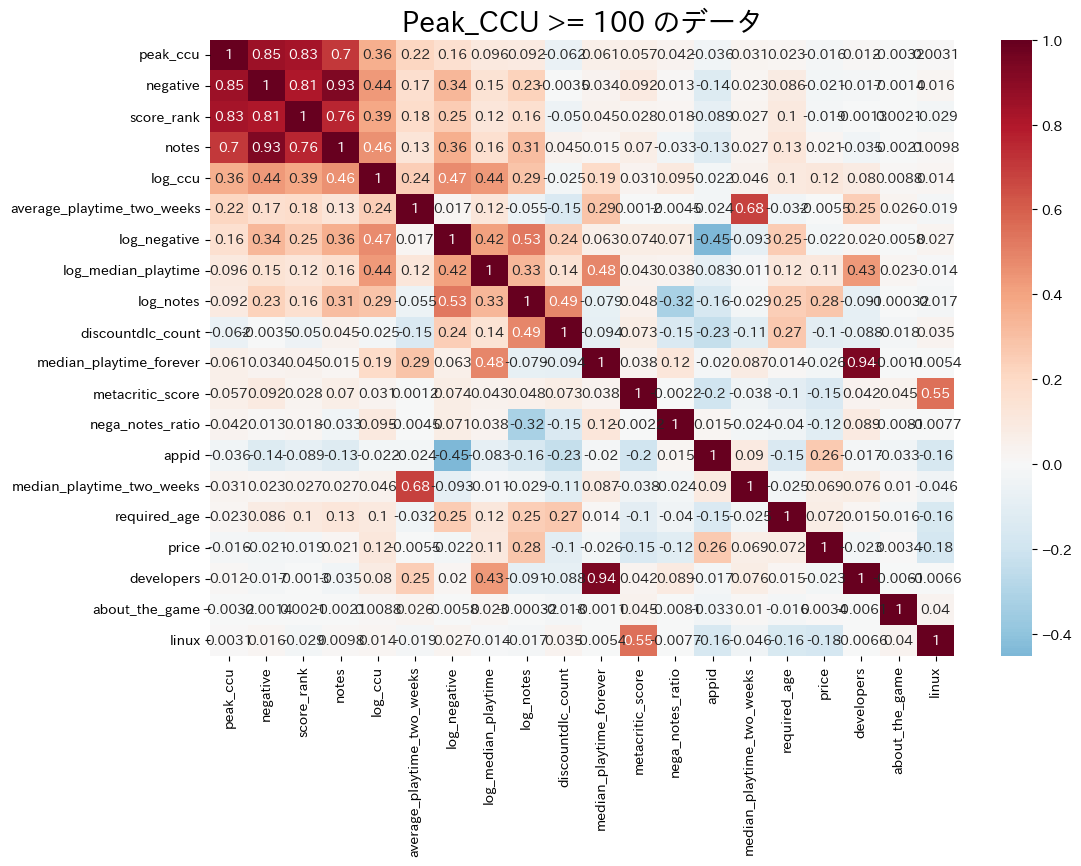

In [27]:
# top_corr_cols = df.corr(numeric_only=True)['peak_ccu'].abs().sort_values(ascending=False).head(20).index
# top_corr_matrix = df[top_corr_cols].corr()

# plt.figure(figsize=(12, 8))
# plt.title('すべてのデータ', size=20)
# sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
# plt.show()

top_corr_cols = df_active.corr(numeric_only=True)['peak_ccu'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df_active[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
plt.title('Peak_CCU > 0 のデータ', size=20)
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

top_corr_cols = df_100.corr(numeric_only=True)['peak_ccu'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df_100[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
plt.title('Peak_CCU >= 100 のデータ', size=20)
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

# top_corr_cols = df_1000.corr(numeric_only=True)['peak_ccu'].abs().sort_values(ascending=False).head(20).index
# top_corr_matrix = df_1000[top_corr_cols].corr()

# plt.figure(figsize=(12, 8))
# plt.title('Peak_CCU >= 1000 のデータ', size=20)
# sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
# plt.show()

In [28]:
zero_count = (df['peak_ccu'] == 0).sum()
print(f"同時接続ゼロのゲーム数: {zero_count} / 全体: {len(df)}")

print(f"log_ccu の最大値: {df['log_ccu'].max()}")

同時接続ゼロのゲーム数: 102935 / 全体: 122611
log_ccu の最大値: 13.829351331025592


In [29]:
formula = "peak_ccu ~ positive"
mod = smf.ols(formula, data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               peak_ccu   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.007804
Date:                Sat, 28 Feb 2026   Prob (F-statistic):              0.930
Time:                        11:32:58   Log-Likelihood:            -1.1823e+06
No. Observations:              122611   AIC:                         2.365e+06
Df Residuals:                  122609   BIC:                         2.365e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.6099     10.652      5.127      0.0

In [30]:
formula = "peak_ccu ~ negative"
mod = smf.ols(formula, data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               peak_ccu   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                 3.105e+05
Date:                Sat, 28 Feb 2026   Prob (F-statistic):               0.00
Time:                        11:32:58   Log-Likelihood:            -1.1050e+06
No. Observations:              122611   AIC:                         2.210e+06
Df Residuals:                  122609   BIC:                         2.210e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -62.8724      5.671    -11.087      0.0

In [31]:
formula = "log_ccu~ log_negative"
mod = smf.ols(formula, data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                 8.016e+04
Date:                Sat, 28 Feb 2026   Prob (F-statistic):               0.00
Time:                        11:32:58   Log-Likelihood:            -1.4788e+05
No. Observations:              122611   AIC:                         2.958e+05
Df Residuals:                  122609   BIC:                         2.958e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.2841      0.003    -89.460   

In [32]:
formula = "peak_ccu ~ positive + price"
mod = smf.ols(formula, data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               peak_ccu   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.337
Date:                Sat, 28 Feb 2026   Prob (F-statistic):              0.263
Time:                        11:32:58   Log-Likelihood:            -1.1823e+06
No. Observations:              122611   AIC:                         2.365e+06
Df Residuals:                  122608   BIC:                         2.365e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     47.9956     11.396      4.211      0.0